# Hard Parameter Sharing for Datasets: FGVC & Naturalist

(multi-label)

*Code Writer: Chaeeun Ryu*

In [1]:
!nvidia-smi

Sat Mar 18 10:07:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:01:00.0 Off |                  Off |
| 30%   30C    P8    21W / 300W |   1315MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:25:00.0 Off |                  Off |
| 30%   

# Import Libraries

In [2]:
import argparse
import os
import random
import time
import warnings
import sys
import numpy as np
import torch
import torch.nn as nn 
import torchvision.transforms as transforms
from collections import Counter, OrderedDict
import torch.optim
from sklearn.metrics import confusion_matrix
from torchvision.datasets import OxfordIIITPet
import os
from torchvision.datasets import FGVCAircraft
from torchvision.datasets import INaturalist
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torchvision.models as models
import glob
import copy
# from torchvision.models import resnet50, ResNet50_Weights
import torchvision
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
device =  torch.device('cuda:5')
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
import torch
import matplotlib.pyplot as plt

'''
Function to visulize image from pytorch tensor
Writer: Chaeeun Ryu
'''
def show_img(img_tensor):
    if img_tensor.size()[0] == 3:
        plt.imshow((img_tensor).permute(1,2,0).detach().cpu().numpy())
        plt.show()
    else:
        plt.imshow((img_tensor).detach().cpu().numpy())
        plt.show()

In [4]:
device

device(type='cuda', index=5)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [6]:
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import copy
def load_pretrained_weight(model):
    pretrained_model = models.resnet50(pretrained=ResNet50_Weights.IMAGENET1K_V2)
    model_weight = copy.deepcopy(model.state_dict())
    pretrained_model_weight = copy.deepcopy(pretrained_model.state_dict())
    idx = 0
    for name, pretrained_weight in zip(model.state_dict().keys(),pretrained_model_weight.values()):
        if idx == 318 or idx == 319:
            pass
        else:
            print(name)
            assert model_weight[name].size() == pretrained_weight.size()
            model_weight[name] = pretrained_weight
        idx+=1
    model.load_state_dict(model_weight)
    idx = 0
    for name, pretrained_weight in zip(model.state_dict().keys(),pretrained_model.state_dict().values()):
        if torch.equal(model.state_dict()[name],pretrained_weight) == True:
            pass
        else:
            print(idx)
    #         model.state_dict()[name] = pretrained_weight
        idx+=1
    print("successfully loaded")
    return model

# Config

In [7]:
from dataclasses import dataclass
global args
@dataclass
class ARGS():
    LR = 0.005
    EPOCHS = 200
    BATCHSIZE = 500
    MOMENTUM = 0.9
    WORKERS = 0
    WEIGHTDECAY = 0
    T_MAX = 150
    CLS_CLASS = 37
    SEG_CLASS = 3
    SIZE = 224
    SEED = 38
    MAX_PATIENCE = 15
    
args = ARGS()

In [8]:
seed_everything(args.SEED)

## Global Transformations

In [9]:
transform_train_without_random = transforms.Compose([
        transforms.Resize((args.SIZE,args.SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_val = transforms.Compose([
        transforms.Resize((args.SIZE,args.SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [10]:
aug_train = transforms.Compose([
        transforms.RandomCrop(args.SIZE, padding=4),
        transforms.RandomHorizontalFlip()
    ])

# FGVCAircraft

In [11]:
global datasets
datasets = dict()

classification_train_dataset_variant = FGVCAircraft(root='./data', split="trainval", annotation_level  = 'variant',download=True, transform=transform_train_without_random)
classification_val_dataset_variant = FGVCAircraft(root='./data', split="test", annotation_level  = 'variant',download=True, transform=transform_val)

classification_train_dataset_family = FGVCAircraft(root='./data', split="trainval", annotation_level  = 'family',download=True, transform=transform_train_without_random)
classification_val_dataset_family = FGVCAircraft(root='./data', split="test", annotation_level  = 'family',download=True, transform=transform_val)

classification_train_dataset_manufacturer = FGVCAircraft(root='./data', split="trainval", annotation_level  = 'manufacturer',download=True, transform=transform_train_without_random)
classification_val_dataset_manufacturer = FGVCAircraft(root='./data', split="test", annotation_level  = 'manufacturer',download=True, transform=transform_val)


datasets['variant'] = {'train_dataset':classification_train_dataset_variant,'val_dataset':classification_val_dataset_variant}
datasets['family'] = {'train_dataset':classification_train_dataset_family,'val_dataset':classification_val_dataset_family}
datasets['manufacturer'] = {'train_dataset':classification_train_dataset_manufacturer,'val_dataset':classification_val_dataset_manufacturer}

In [12]:
datasets.keys()

dict_keys(['variant', 'family', 'manufacturer'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


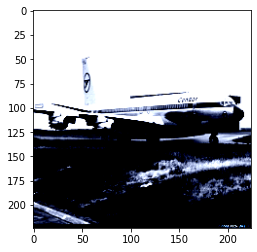

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


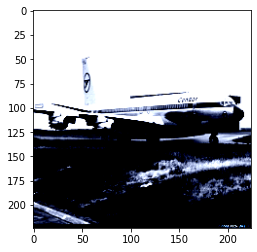

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


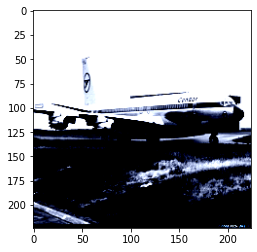

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


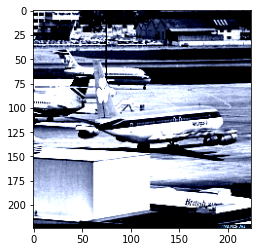

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


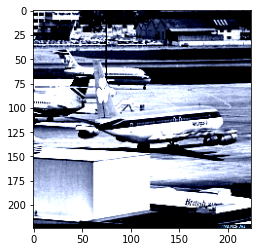

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


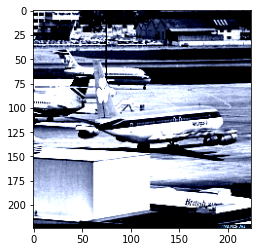

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


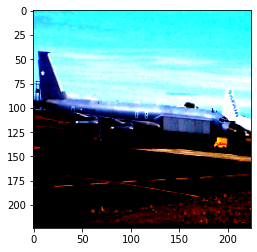

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


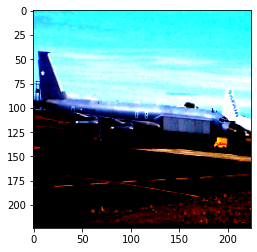

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


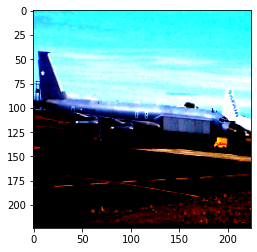

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


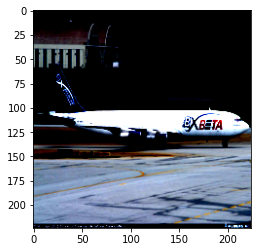

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


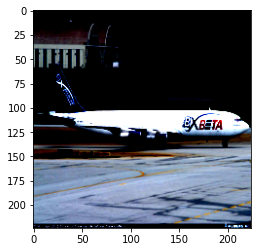

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


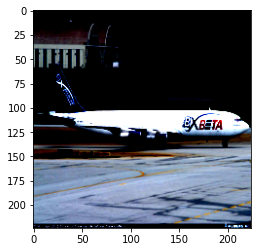

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


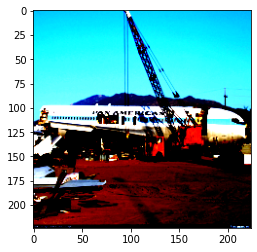

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


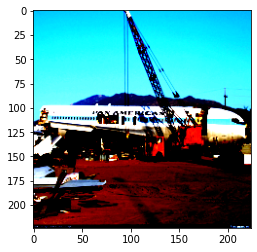

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


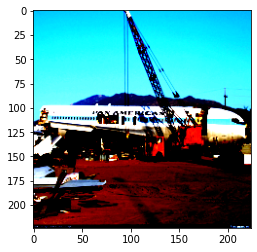

In [13]:
for idx in range(5):
    img1,label1 = classification_train_dataset_variant.__getitem__(idx)
    img2,label2 = classification_train_dataset_family.__getitem__(idx)
    img3,label3 = classification_train_dataset_manufacturer.__getitem__(idx)
    assert torch.equal(img1,img2) ==True
    assert torch.equal(img2,img3) == True
    assert torch.equal(img1,img3) == True
    show_img(img1)
    show_img(img2)
    show_img(img3)

In [14]:
from torch.utils.data import Dataset

class JointFGVCDataset_Train(Dataset): 
    def __init__(self,datasets_dict,aug_train):
        self.dataset_dict = datasets_dict
        self.aug_train = aug_train
        
    def __len__(self): 
        return self.dataset_dict['variant']['train_dataset'].__len__()

    def __getitem__(self, idx):
        img,label_variant = self.dataset_dict['variant']['train_dataset'].__getitem__(idx)
        img,label_family = self.dataset_dict['family']['train_dataset'].__getitem__(idx)
        img,label_manufacturer = self.dataset_dict['manufacturer']['train_dataset'].__getitem__(idx)
        
        img = self.aug_train(img)
        return img, label_variant,label_family,label_manufacturer

In [15]:
from torch.utils.data import Dataset

class JointFGVCDataset_Val(Dataset): 
    def __init__(self,datasets_dict):
        self.dataset_dict = datasets_dict
        
    def __len__(self): 
        return self.dataset_dict['variant']['val_dataset'].__len__()

    def __getitem__(self, idx):
        img,label_variant = self.dataset_dict['variant']['val_dataset'].__getitem__(idx)
        img,label_family = self.dataset_dict['family']['val_dataset'].__getitem__(idx)
        img,label_manufacturer = self.dataset_dict['manufacturer']['val_dataset'].__getitem__(idx)
        
        return img, label_variant,label_family,label_manufacturer

In [16]:
joint_FGVC_train_set = JointFGVCDataset_Train(datasets,aug_train)
joint_FGVC_val_set = JointFGVCDataset_Val(datasets)

In [17]:
global data_classes
data_classes = dict()
data_classes['variant'] = len(classification_train_dataset_variant.classes)
assert len(classification_train_dataset_variant.classes) == len(classification_val_dataset_variant.classes)
data_classes['family'] = len(classification_train_dataset_family.classes)
assert len(classification_train_dataset_family.classes) == len(classification_val_dataset_family.classes)
data_classes['manufacturer'] = len(classification_train_dataset_manufacturer.classes)
assert len(classification_train_dataset_manufacturer.classes) == len(classification_val_dataset_manufacturer.classes)

In [18]:
data_classes

{'variant': 100, 'family': 70, 'manufacturer': 30}

In [19]:
global data_loaders
data_loaders = dict()

joint_train_loader = torch.utils.data.DataLoader(
    joint_FGVC_train_set, batch_size=args.BATCHSIZE, shuffle=True,
    num_workers=args.WORKERS, pin_memory=True)
joint_val_loader = torch.utils.data.DataLoader(
    joint_FGVC_val_set, batch_size=args.BATCHSIZE, shuffle=False,
    num_workers=args.WORKERS, pin_memory=True)

data_loaders= {'train_loader':joint_train_loader,'val_loader':joint_val_loader}

In [20]:
data_loaders.keys()

dict_keys(['train_loader', 'val_loader'])

# Classification

In [21]:
data_classes

{'variant': 100, 'family': 70, 'manufacturer': 30}

In [22]:
'''ResNet in PyTorch.
Reference:
https://github.com/kuangliu/pytorch-cifar
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace = True) 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         print("block.expansion:",block.expansion) == 1
#         self.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.linear_variant = nn.Linear(512*block.expansion, data_classes['variant'])
        self.linear_family = nn.Linear(512*block.expansion, data_classes['family'])
        self.linear_manufacturer = nn.Linear(512*block.expansion, data_classes['manufacturer'])

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
#         out = F.avg_pool2d(out4, 4)
        out = self.avgpool(out4)
        out = out.view(out.size(0), -1)
        out_variant, out_family, out_manufacturer = self.linear_variant(out),self.linear_family(out),self.linear_manufacturer(out)
        
        return out_variant,out_family,out_manufacturer#, [out1, out2, out3, out4]


def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

In [23]:
resnet50 = ResNet50()
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [24]:
resnet50 = load_pretrained_weight(resnet50)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.bn3.running_mean
layer1.0.bn3.running_var
layer1.0.bn3.num_batches_tracked
layer1.0.shortcut.0.weight
layer1.0.shortcut.1.weight
layer1.0.shortcut.1.bias
layer1.0.shortcut.1.running_mean
layer1.0.shortcut.1.running_var
layer1.0.shortcut.1.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer1

In [25]:
cls_criterion = nn.CrossEntropyLoss().to(device)

In [26]:
def train_cls(epoch,train_loader,model,seg_criterion, optimizer, device=device, cls_criterion = cls_criterion):
    assert seg_criterion == None
    ss_losses = []
    ss_losses_dict = {"variant":0,"family":0,"manufacturer":0}
    save_ss_acc = []
    save_ss_acc_dict = {"variant":0,"family":0,"manufacturer":0}
    
    model.to(device)
    model.train()
    n_iter = 0
    if epoch == 0:
        for image, label_variant,label_family,label_manufacturer in tqdm(train_loader):
            n_iter +=1
            image,label_variant,label_family,label_manufacturer = image.to(device), label_variant.to(device),label_family.to(device),label_manufacturer.to(device)
            surrogate_out_variant,surrogate_out_family,surrogate_out_manufacturer = model(image)
            
            #pred
            surrogate_pred_variant = torch.argmax(surrogate_out_variant,axis = 1)
            surrogate_pred_family = torch.argmax(surrogate_out_family,axis = 1)
            surrogate_pred_manufacturer = torch.argmax(surrogate_out_manufacturer,axis = 1)
            
            #loss
            cls_loss_variant = cls_criterion(surrogate_out_variant, label_variant)
            cls_loss_family = cls_criterion(surrogate_out_family,label_family)
            cls_loss_manufacturer = cls_criterion(surrogate_out_manufacturer,label_manufacturer)
            loss = cls_loss_variant+cls_loss_family+cls_loss_manufacturer
            loss_dict = {"variant":cls_loss_variant.item(),"family":cls_loss_family.item(),"manufacturer":cls_loss_manufacturer.item()}
            ss_losses_dict['variant'] += loss_dict['variant']
            ss_losses_dict['family'] += loss_dict['family']
            ss_losses_dict['manufacturer'] += loss_dict['manufacturer']
            
            avg_loss = np.mean(list(loss_dict.values()))
            ss_losses.append(avg_loss)
            
            #acc
            acc1_variant = (torch.sum((surrogate_pred_variant==label_variant)*1)/len(label_variant)).item()
            acc1_family = (torch.sum((surrogate_pred_family==label_family)*1)/len(label_family)).item()
            acc1_manufacturer = (torch.sum((surrogate_pred_manufacturer==label_manufacturer)*1)/len(label_manufacturer)).item()
            
            acc_dict = {'variant': acc1_variant, 'family':acc1_family,'manufacturer':acc1_manufacturer}
            avg_acc = np.mean(list(acc_dict.values()))
            save_ss_acc.append(avg_acc)
            
            save_ss_acc_dict['variant'] += acc_dict['variant']
            save_ss_acc_dict['family'] += acc_dict['family']
            save_ss_acc_dict['manufacturer'] += acc_dict['manufacturer']
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        ss_losses_dict['variant'],ss_losses_dict['family'],ss_losses_dict['manufacturer'] =ss_losses_dict['variant']/n_iterter,ss_losses_dict['family']/n_iter,ss_losses_dict['manufacturer']/n_iteriter
        save_ss_acc_dict['variant'],save_ss_acc_dict['family'],save_ss_acc_dict['manufacturer'] =save_ss_acc_dict['variant']/n_iterter,save_ss_acc_dict['family']/n_iter,save_ss_acc_dict['manufacturer']/n_iteriter
  
        return np.mean(ss_losses),np.mean(save_ss_acc),ss_losses_dict,save_ss_acc_dict
    else:
        for image, label in train_loader:
            n_iter +=1
            image,label_variant,label_family,label_manufacturer = image.to(device), label_variant.to(device),label_family.to(device),label_manufacturer.to(device)
            surrogate_out_variant,surrogate_out_family,surrogate_out_manufacturer = model(image)
            
            #pred
            surrogate_pred_variant = torch.argmax(surrogate_out_variant,axis = 1)
            surrogate_pred_family = torch.argmax(surrogate_out_family,axis = 1)
            surrogate_pred_manufacturer = torch.argmax(surrogate_out_manufacturer,axis = 1)
            
            #loss
            cls_loss_variant = cls_criterion(surrogate_out_variant, label_variant)
            cls_loss_family = cls_criterion(surrogate_out_family,label_family)
            cls_loss_manufacturer = cls_criterion(surrogate_out_manufacturer,label_manufacturer)
            loss = cls_loss_variant+cls_loss_family+cls_loss_manufacturer
            loss_dict = {"variant":cls_loss_variant.item(),"family":cls_loss_family.item(),"manufacturer":cls_loss_manufacturer.item()}
            ss_losses_dict['variant'] += loss_dict['variant']
            ss_losses_dict['family'] += loss_dict['family']
            ss_losses_dict['manufacturer'] += loss_dict['manufacturer']
            avg_loss = np.mean(list(loss_dict.values()))
            ss_losses.append(avg_loss)
            
            #acc
            acc1_variant = (torch.sum((surrogate_pred_variant==label_variant)*1)/len(label_variant)).item()
            acc1_family = (torch.sum((surrogate_pred_family==label_family)*1)/len(label_family)).item()
            acc1_manufacturer = (torch.sum((surrogate_pred_manufacturer==label_manufacturer)*1)/len(label_manufacturer)).item()
            
            acc_dict = {'variant': acc1_variant, 'family':acc1_family,'manufacturer':acc1_manufacturer}
            save_ss_acc_dict['variant'] += acc_dict['variant']
            save_ss_acc_dict['family'] += acc_dict['family']
            save_ss_acc_dict['manufacturer'] += acc_dict['manufacturer']
            avg_acc = np.mean(list(acc_dict.values()))
            save_ss_acc.append(avg_acc)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        ss_losses_dict['variant'],ss_losses_dict['family'],ss_losses_dict['manufacturer'] =ss_losses_dict['variant']/n_iterter,ss_losses_dict['family']/n_iter,ss_losses_dict['manufacturer']/n_iteriter
        save_ss_acc_dict['variant'],save_ss_acc_dict['family'],save_ss_acc_dict['manufacturer'] =save_ss_acc_dict['variant']/n_iterter,save_ss_acc_dict['family']/n_iter,save_ss_acc_dict['manufacturer']/n_iteriter
        return np.mean(ss_losses),np.mean(save_ss_acc),ss_losses_dict,save_ss_acc_dict

In [27]:
def eval_cls(val_loader, model, seg_criterion, device, cls_criterion = cls_criterion):
    assert seg_criterion == None
    ss_losses = []
    ss_losses_dict = {"variant":0,"family":0,"manufacturer":0}
    save_ss_acc = []
    save_ss_acc_dict = {"variant":0,"family":0,"manufacturer":0}
    n_iter = 0
    model.eval()
    with torch.no_grad():
        for image,label in val_loader:
            n_iter +=1
            image,label_variant,label_family,label_manufacturer = image.to(device), label_variant.to(device),label_family.to(device),label_manufacturer.to(device)
            surrogate_out_variant,surrogate_out_family,surrogate_out_manufacturer = model(image)
            
            #pred
            surrogate_pred_variant = torch.argmax(surrogate_out_variant,axis = 1)
            surrogate_pred_family = torch.argmax(surrogate_out_family,axis = 1)
            surrogate_pred_manufacturer = torch.argmax(surrogate_out_manufacturer,axis = 1)
            
            #loss
            cls_loss_variant = cls_criterion(surrogate_out_variant, label_variant)
            cls_loss_family = cls_criterion(surrogate_out_family,label_family)
            cls_loss_manufacturer = cls_criterion(surrogate_out_manufacturer,label_manufacturer)
            loss = cls_loss_variant+cls_loss_family+cls_loss_manufacturer
            loss_dict = {"variant":cls_loss_variant.item(),"family":cls_loss_family.item(),"manufacturer":cls_loss_manufacturer.item()}
            ss_losses_dict['variant'] += loss_dict['variant']
            ss_losses_dict['family'] += loss_dict['family']
            ss_losses_dict['manufacturer'] += loss_dict['manufacturer']
            avg_loss = np.mean(list(loss_dict.values()))
            ss_losses.append(avg_loss)
            
            #acc
            acc1_variant = (torch.sum((surrogate_pred_variant==label_variant)*1)/len(label_variant)).item()
            acc1_family = (torch.sum((surrogate_pred_family==label_family)*1)/len(label_family)).item()
            acc1_manufacturer = (torch.sum((surrogate_pred_manufacturer==label_manufacturer)*1)/len(label_manufacturer)).item()
            
            acc_dict = {'variant': acc1_variant, 'family':acc1_family,'manufacturer':acc1_manufacturer}
            save_ss_acc_dict['variant'] += acc_dict['variant']
            save_ss_acc_dict['family'] += acc_dict['family']
            save_ss_acc_dict['manufacturer'] += acc_dict['manufacturer']
            avg_acc = np.mean(list(acc_dict.values()))
            save_ss_acc.append(avg_acc)

        ss_losses_dict['variant'],ss_losses_dict['family'],ss_losses_dict['manufacturer'] =ss_losses_dict['variant']/n_iterter,ss_losses_dict['family']/n_iter,ss_losses_dict['manufacturer']/n_iteriter
        save_ss_acc_dict['variant'],save_ss_acc_dict['family'],save_ss_acc_dict['manufacturer'] =save_ss_acc_dict['variant']/n_iterter,save_ss_acc_dict['family']/n_iter,save_ss_acc_dict['manufacturer']/n_iteriter
        return np.mean(ss_losses),np.mean(save_ss_acc),ss_losses_dict,save_ss_acc_dict

In [28]:
ch_unet_optimizer = torch.optim.SGD(resnet50.parameters(), args.LR,
                            momentum=args.MOMENTUM,
                            weight_decay=args.WEIGHTDECAY)
ch_unet_scheduler = CosineAnnealingLR(ch_unet_optimizer, T_max = args.T_MAX)

In [ ]:
from tqdm.notebook import tqdm

save_ss_train_loss = []
save_ss_val_loss = []
save_ss_train_acc = []
save_ss_val_acc = []

ss_best_val_acc = 0.

that_time_acc= None
max_patience = args.MAX_PATIENCE
resnet50.to(device)
seg_criterion = None

print("training starting..")

for epoch in tqdm(range(args.EPOCHS)):
    ss_train_loss,ss_train_acc,train_loss_dict,train_acc_dict = train_cls(epoch,data_loaders['train_loader'], resnet50, seg_criterion, ch_unet_optimizer,device, cls_criterion)
    ss_val_loss,ss_val_acc,val_loss_dict,val_acc_dict = eval_cls(data_loaders['val_loader'], resnet50, seg_criterion, device, cls_criterion)
    
    #self-supervision
    save_ss_train_loss.append(ss_train_loss)
    save_ss_train_acc.append(ss_train_acc)
    save_ss_val_loss.append(ss_val_loss)
    save_ss_val_acc.append(ss_val_acc)
    
    print(f"======= epoch {epoch} ========")
    print("avg train acc:",ss_train_acc,"avg val acc:",ss_val_acc, "ss train loss:",ss_train_loss, "ss val loss:",ss_val_loss)
    print("train acc:",train_acc_dict)
    print("val acc:",val_acc_dict)
    print("train loss:",train_loss_dict)
    print("val liss:",val_loss_dict)
    
    if epoch%20 == 0:
        print(f"best average acc so far:{ss_best_val_acc}")
    if ss_val_acc > ss_best_val_acc:
        print("model updated at epoch:",epoch,"avg val acc:",ss_val_acc)
        best_model = copy.deepcopy(resnet50)
        ss_best_val_acc = ss_val_acc
        patience = 0
    else:
        patience +=1
    
    if patience > max_patience:
        print("patience overloaded..! stop learning.........")
        break
        
    ch_unet_scheduler.step()

#지금까지 high score: 0.87

training starting..


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
max(save_ss_val_acc)

In [ ]:
log_dict = dict()
# log_dict['save_train_loss'] = save_train_loss
# log_dict['save_val_loss'] = save_val_loss
# log_dict['save_train_dice'] = save_train_dice
# log_dict['save_val_dice'] = save_val_dice
log_dict['save_ss_train_acc'] = save_ss_train_acc
log_dict['save_ss_val_acc'] = save_ss_val_acc
log_dict['save_ss_train_loss'] = save_ss_train_loss
log_dict['save_ss_val_loss'] = save_ss_val_loss

In [ ]:
torch.save(log_dict,f"./{d_name}hard_param_FGVC_resnet50_log.pt")
torch.save({"model_w":resnet50.state_dict(),"best_model_w":best_model.state_dict()},f"./hard_param_FGVC_resnet50_w.pt")

In [ ]:
plt.title("Saved loss for HardParam (ResNet50)")
plt.plot(save_ss_train_loss,label = "train loss")
plt.plot(save_ss_val_loss, label = "valid loss")
plt.legend()
plt.show()

In [ ]:
plt.title("Saved acc for HardParam (ResNet50)")
plt.plot(save_ss_train_acc,label = "train")
plt.plot(save_ss_val_acc,label = "valid")
plt.legend()
plt.show()